In [135]:
pip install wordcloud

     |████████████████████████████████| 220 kB 3.2 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl size=158971 sha256=9a59dc180f62af62cd8a5d3c74892c6e4b2522d06bea6098a2f8452fbcd72192
  Stored in directory: /Users/toeyscn/Library/Caches/pip/wheels/f8/f6/55/6bd394c32a844a621ca0fe5dbf563c8d71d71edaf095656991
Successfully built wordcloud
Note: you may need to restart the kernel to use updated packages.


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
import pandas as pd

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
#         self.grouped_by_Helpful = self.grouped_by_Helpful()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
#     add on another feature that might help 
#     def grouped_by_Helpful(self):
#         """grouped_by_Helpful and look at the distribution of number of reviews"""
#         grouped_by_Helpful = self.raw_data.groupby('helpful').count()
#         print('Distribution of number of reviews for each UserId:')
#         print(grouped_by_Helpful['helpful'].value_counts())
#         print(50 * '-')
#         return grouped_by_Helpful
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        # remove unhelpful comments 
#         filtered2 = self.grouped_by_Helpful[self.grouped_by_Helpful['helpful'] : FALSE]
         # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        filtered_final.reset_index(drop=True, inplace=True)
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered


    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        print("Data grouped by ProductId has", grouped_by_pid.shape[0], "rows and", grouped_by_pid.shape[1], "columns. First five observations:")
        print(grouped_by_pid.head(5))
        print(50 * '-')
        return grouped_by_pid
    
    
#     def train_test(self):
#         #Train-Test split
#         X=self['helpScore'].values
#         Y=self['Score'].values
#         from sklearn.model_selection import train_test_split
#         X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3) #random splitting
#         X_train,X_cv,Y_train,Y_cv=train_test_split(X_train,Y_train,test_size=0.3) #random splitting
#         print(X_train.shape,Y_train.shape)
#         print(X_test.shape,Y_test.shape)
#         print(X_cv.shape,Y_cv.shape)
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        #featurization_using_Bow
        from sklearn.feature_extraction.text import CountVectorizer
        count = CountVectorizer()
        uidArray = self.grouped_by_productid.UserId
        userFeatures = count.fit_transform(uidArray)
        print("Shape of final X matrix:", userFeatures.shape)
        return userFeatures

In [233]:
import pandas as pd
from wordcloud import WordCloud

    
class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds','cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text','helpful']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))
    
    def onlysize(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster: ', i)
            print('cluster size: ', cluster.shape)
            
    def wordcloud(self, n_samples):
        merged = self.merge_labels()
        list_of_words_str = ' '.join(merged)
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            cluster = list_of_words_str.loc[list_of_words_str['cluster'] == i]
            wc = WordCloud(background_color="white", max_words=len(merged),width=1080, height=720,min_font_size = 10, collocations=False)
            wc.generate(cluster)
            plt.figure(figsize=(10,10))
            print ("\n\nWord Cloud for Important features")
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()


In [94]:
# process Amazon.csv, filtering out people who left 4 or fewer reviews
amazonData = ProcessAmazon('/Users/toeyscn/Downloads/ml-master/final_assignment_3/option_1/Data/Amazon.csv', 4)

/Users/toeyscn/Downloads/ml-master/final_assignment_3/option_1/Data/Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400   

                

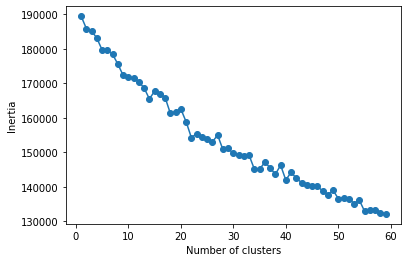

In [147]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 60):
    km = KMeans(n_clusters=i,n_jobs=-1)
    km.fit(amazonData.X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 60), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [274]:
# fit KMeans with 45 clusters
from sklearn.cluster import KMeans
optimal_k= 21
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(amazonData.X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=21, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [275]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, kmeans)

In [276]:
# view samples of product reviews, organized by KMeans cluster results
viz.view_cluster_samples(10)

--------------------------------------------------
cluster:  1
cluster size:  (724, 5)
         ProductId  cluster  \
377036  B008RWUKXK        1   
376795  B008RWUHA6        1   
376775  B008RWUHA6        1   
376797  B008RWUHA6        1   
376964  B008RWUKXK        1   
376841  B008RWUHA6        1   
376764  B008RWUHA6        1   
376790  B008RWUHA6        1   
377059  B008RWUKXK        1   
334126  B005IW4WFY        1   

                                                  Summary  \
377036  KIND Healthy Grains Clusters, Dark Chocolate &...   
376795                                             delish   
376775                                        Delicious!!   
376797  Good product, but shop around based on protein...   
376964  A bit too sweet and pricey, but it's a delicio...   
376841                            Healthy AND tasty. Wow.   
376764                                         Very tasty   
376790                    Even my picky eater loves this!   
377059                

In [277]:
# view number of nodes in each cluster
viz.onlysize(50)

cluster:  1
cluster size:  (724, 5)
cluster:  2
cluster size:  (1102, 5)
cluster:  3
cluster size:  (1644, 5)
cluster:  4
cluster size:  (1018, 5)
cluster:  5
cluster size:  (682, 5)
cluster:  6
cluster size:  (2059, 5)
cluster:  7
cluster size:  (4097, 5)
cluster:  8
cluster size:  (742, 5)
cluster:  9
cluster size:  (1697, 5)
cluster:  10
cluster size:  (3270, 5)
cluster:  11
cluster size:  (1021, 5)
cluster:  12
cluster size:  (1212, 5)
cluster:  13
cluster size:  (1316, 5)
cluster:  14
cluster size:  (1456, 5)
cluster:  15
cluster size:  (329, 5)
cluster:  16
cluster size:  (3445, 5)
cluster:  17
cluster size:  (969, 5)
cluster:  18
cluster size:  (1513, 5)
cluster:  19
cluster size:  (1298, 5)
cluster:  20
cluster size:  (1262, 5)
